In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import torch
import gpytorch
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import tqdm
import utils as utils
import scienceplots
plt.style.use('science')

base_dir = os.path.join(os.getcwd(), '..')
sys.path.append(base_dir)

import fit_FaIRGP as fairgp
from src.structures import Scenario, ScenarioDataset
from src.evaluation import metrics

<IPython.core.display.Javascript object>

In [3]:
xr_forcing = xr.open_dataarray('../data/forcing.nc')
weights = np.cos(np.deg2rad(xr_forcing.lat))
xr_forcing_glob = xr_forcing.weighted(weights).mean(['lat', 'lon'])
groundtruth_historical_forcing = torch.from_numpy(xr_forcing_glob.values).float()

In [4]:
train_cfg = {'dataset' : {'dirpath': '../data/', 
                          'keys': ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']}
            }
train_data = fairgp.make_data(train_cfg)

# test_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['ssp126', 'ssp245', 'ssp370', 'ssp585']}}
# test_data = plaingp.make_data(test_cfg)

fairgpmodel = fairgp.make_model(train_cfg, train_data)
state_dict = torch.load('../data/models/all-ssps/FaIRGP/state_dict.pt')
fairgpmodel.load_state_dict(state_dict)

<All keys matched successfully>

In [5]:
test_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']}}
test_data = fairgp.make_data(test_cfg)
test_scenarios = test_data.scenarios
for s in test_scenarios.scenarios.values():
    s.name = s.name + '-test'

In [8]:
observation_noise = 0.5**2

with torch.no_grad():
    posterior_F = fairgpmodel.forcing_posterior(test_scenarios)
    posterior_mean = posterior_F.mean
    posterior_lb, posterior_ub = posterior_F.confidence_region()
    posterior_var = posterior_F.variance
    posterior_lb = posterior_mean - torch.sqrt(posterior_var + observation_noise)
    posterior_ub = posterior_mean + torch.sqrt(posterior_var + observation_noise)

In [9]:
mT = fairgpmodel._compute_mean(test_scenarios)
mF = fairgpmodel._compute_forcing_mean(test_scenarios)

In [10]:
foo = [slice(165, 165 + 86),
       slice(165 + 86, 165 + 2 * 86),
       slice(165 + 2* 86, 165 + 3 * 86),
       slice(165 + 3*86, 165 + 4 * 86)]

In [11]:
choice = 'viridis'
cmap = matplotlib.cm.get_cmap(choice)
tas_colors = [cmap(0.), cmap(0.4), cmap(0.6), cmap(0.8), cmap(0.95)]

cmap = matplotlib.cm.get_cmap(choice)
forcing_colors = [cmap(0.), cmap(0.4), cmap(0.6), cmap(0.8), cmap(0.95)]

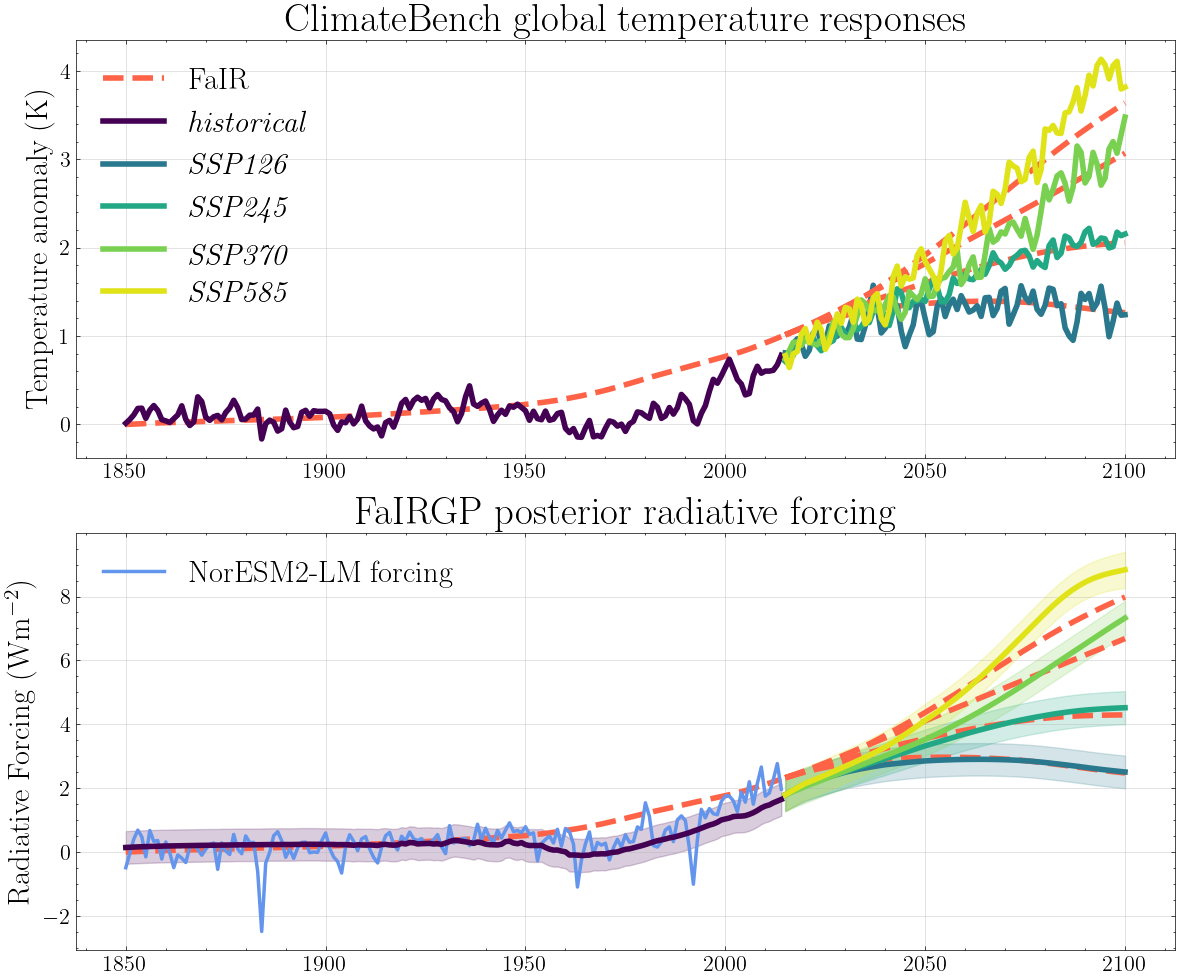

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

ax[0].plot(test_scenarios.hist_scenario.timesteps,
           mT[test_scenarios.full_slices['historical']], color='tomato', ls='--', lw=4, label='FaIR')
ax[0].plot(test_scenarios.hist_scenario.timesteps,
           test_scenarios.hist_scenario.tas, lw=4, color=tas_colors[0], label=r'$\it historical$')
ax[0].tick_params(labelsize=16)
ax[0].set_ylabel('Temperature anomaly (K)', fontsize=22)
ax[0].grid(alpha=0.5)
ax[0].set_title(r'ClimateBench global temperature responses', fontsize=28)



ax[1].plot(test_scenarios.hist_scenario.timesteps,
           mF[test_scenarios.full_slices['historical']], color='tomato', ls='--', lw=4)
ax[1].plot(test_scenarios.hist_scenario.timesteps,
           groundtruth_historical_forcing, color='cornflowerblue', lw=2.5, label='NorESM2-LM forcing')
ax[1].plot(test_scenarios.hist_scenario.timesteps,
           posterior_mean[test_scenarios.full_slices['historical']], color=forcing_colors[0], lw=4)
ax[1].fill_between(test_scenarios.hist_scenario.timesteps,
                   posterior_lb[test_scenarios.full_slices['historical']], 
                   posterior_ub[test_scenarios.full_slices['historical']], alpha=0.2, color=forcing_colors[0])


for i, key in enumerate(['ssp126', 'ssp245', 'ssp370', 'ssp585']):
    ax[0].plot(test_scenarios[key].timesteps,
               mT[foo[i]], color='tomato', ls='--', lw=4)
    ax[0].plot(test_scenarios[key].timesteps, 
               test_scenarios[key].tas, lw=4, color=tas_colors[i + 1], label=f'$\it {key.upper()}$')
    
    ax[1].plot(test_scenarios[key].timesteps,
               mF[foo[i]], color='tomato', ls='--', lw=4)
    ax[1].plot(test_scenarios[key].timesteps,
               posterior_mean[foo[i]], color=forcing_colors[i + 1], lw=4)
    ax[1].fill_between(test_scenarios[key].timesteps,
                       posterior_lb[foo[i]], 
                       posterior_ub[foo[i]], alpha=0.2, color=forcing_colors[i + 1])


ax[1].tick_params(labelsize=16)
ax[1].set_ylabel(r'Radiative Forcing (Wm$^{-2}$)', fontsize=22)
ax[1].grid(alpha=0.5)
ax[1].set_title(r'FaIRGP posterior radiative forcing', fontsize=28)


    
ax[0].legend(loc='upper left', fontsize=22)
# legend.legendHandles[4].set_alpha(0.4)

ax[1].legend(loc='upper left', fontsize=22)

plt.tight_layout()
# plt.savefig('./figures/forcing-posterior-paper-figure.png', dpi=200)
plt.show()

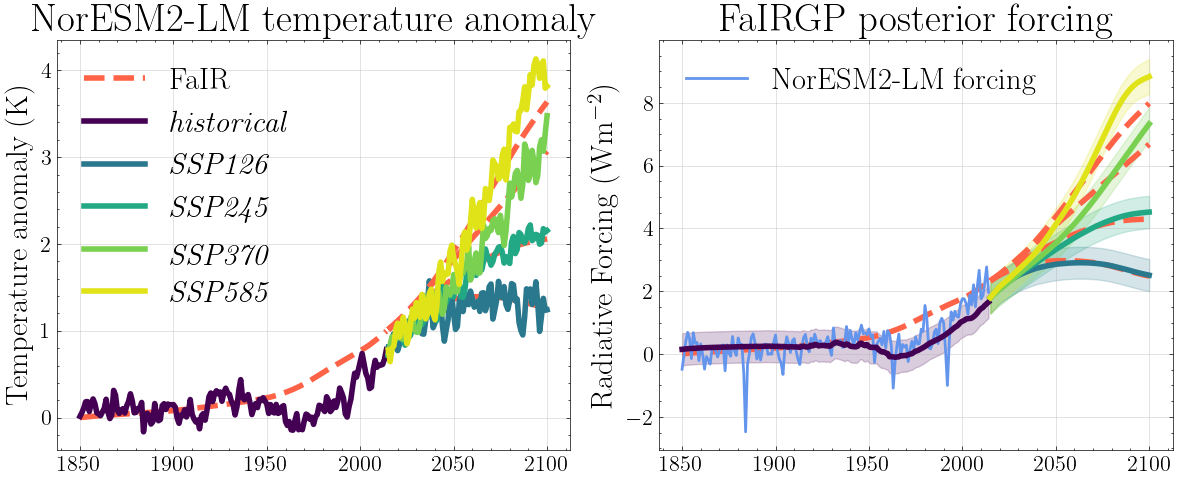

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(test_scenarios.hist_scenario.timesteps,
           mT[test_scenarios.full_slices['historical']], color='tomato', ls='--', lw=4, label='FaIR')
ax[0].plot(test_scenarios.hist_scenario.timesteps,
           test_scenarios.hist_scenario.tas, lw=4, color=tas_colors[0], label=r'$\it historical$')
ax[0].tick_params(labelsize=16)
ax[0].set_ylabel('Temperature anomaly (K)', fontsize=22)
ax[0].grid(alpha=0.5)
ax[0].set_title(r'NorESM2-LM temperature anomaly', fontsize=28)



ax[1].plot(test_scenarios.hist_scenario.timesteps,
           mF[test_scenarios.full_slices['historical']], color='tomato', ls='--', lw=4)
ax[1].plot(test_scenarios.hist_scenario.timesteps,
           groundtruth_historical_forcing, color='cornflowerblue', lw=2, label='NorESM2-LM forcing')
ax[1].plot(test_scenarios.hist_scenario.timesteps,
           posterior_mean[test_scenarios.full_slices['historical']], color=forcing_colors[0], lw=4)
ax[1].fill_between(test_scenarios.hist_scenario.timesteps,
                   posterior_lb[test_scenarios.full_slices['historical']], 
                   posterior_ub[test_scenarios.full_slices['historical']], alpha=0.2, color=forcing_colors[0])


for i, key in enumerate(['ssp126', 'ssp245', 'ssp370', 'ssp585']):
    ax[0].plot(test_scenarios[key].timesteps,
               mT[foo[i]], color='tomato', ls='--', lw=4)
    ax[0].plot(test_scenarios[key].timesteps, 
               test_scenarios[key].tas, lw=4, color=tas_colors[i + 1], label=f'$\it {key.upper()}$')
    
    ax[1].plot(test_scenarios[key].timesteps,
               mF[foo[i]], color='tomato', ls='--', lw=4)
    ax[1].plot(test_scenarios[key].timesteps,
               posterior_mean[foo[i]], color=forcing_colors[i + 1], lw=4)
    ax[1].fill_between(test_scenarios[key].timesteps,
                       posterior_lb[foo[i]], 
                       posterior_ub[foo[i]], alpha=0.2, color=forcing_colors[i + 1])


ax[1].tick_params(labelsize=16)
ax[1].set_ylabel(r'Radiative Forcing (Wm$^{-2}$)', fontsize=22)
ax[1].grid(alpha=0.5)
ax[1].set_title(r'FaIRGP posterior forcing', fontsize=28)


    
legend = ax[0].legend(loc='upper left', fontsize=22)
# legend.legendHandles[4].set_alpha(0.4)

ax[1].legend(loc='upper left', fontsize=22)

plt.tight_layout()
# plt.savefig('./figures/forcing-posterior-paper-figure-transpose.png', dpi=200)
plt.show()

In [26]:
hist_mean = posterior_F.mean[test_scenarios.full_slices['historical']]
hist_stddev = torch.sqrt(posterior_F.variance[test_scenarios.full_slices['historical']] + observation_noise)

hist_pred = torch.distributions.Normal(hist_mean, hist_stddev)

scores_fairgp = {**metrics.compute_deterministic_metrics(hist_pred.mean, groundtruth_historical_forcing),
                 **metrics.compute_probabilistic_metrics(hist_pred, groundtruth_historical_forcing)}

scores_fair = metrics.compute_deterministic_metrics(mF[test_scenarios.full_slices['historical']],
                                                    groundtruth_historical_forcing)

scores_hist = [scores_fair, scores_fairgp]
scores_hist_df = pd.DataFrame(scores_hist)
scores_hist_df.index = ['FaIR', 'FaIRGP']
scores_hist_df.index.name = 'Emulator'
scores_hist_df.columns = ['Bias', 'RMSE', 'MAE', 'Corr', 'LL', 'Calib95', 'CRPS', 'ICI']
scores_hist_df = scores_hist_df[['RMSE', 'MAE', 'Bias', 'LL', 'Calib95', 'CRPS']]
scores_hist_df

,RMSE,MAE,Bias,LL,Calib95,CRPS
Emulator,,,,,,
FaIR,0.536026,0.367579,0.191694,NaN,NaN,NaN
FaIRGP,0.486523,0.359055,-0.104195,-0.700129,0.963636,0.258813


In [27]:
start, end = 1950, 2014
time_slice = slice(start - end, None)

hist_mean = posterior_F.mean[test_scenarios.full_slices['historical']]
hist_stddev = torch.sqrt(posterior_F.variance[test_scenarios.full_slices['historical']] + observation_noise)

hist_pred = torch.distributions.Normal(hist_mean[time_slice], hist_stddev[time_slice])
gt = groundtruth_historical_forcing[time_slice]
mF_slice = mF[test_scenarios.full_slices['historical']][time_slice]

scores_fairgp = {**metrics.compute_deterministic_metrics(hist_pred.mean, gt),
                 **metrics.compute_probabilistic_metrics(hist_pred, gt)}

scores_fair = metrics.compute_deterministic_metrics(mF_slice,
                                                    gt)

scores_1950_present = [scores_fair, scores_fairgp]
scores_1950_present_df = pd.DataFrame(scores_1950_present)
scores_1950_present_df.index = ['FaIR', 'FaIRGP']
scores_1950_present_df.index.name = 'Emulator'
scores_1950_present_df.columns = ['Bias', 'RMSE', 'MAE', 'Corr', 'LL', 'Calib95', 'CRPS', 'ICI']
scores_1950_present_df = scores_1950_present_df[['RMSE', 'MAE', 'Bias', 'LL', 'Calib95', 'CRPS']]
scores_1950_present_df

,RMSE,MAE,Bias,LL,Calib95,CRPS
Emulator,,,,,,
FaIR,0.705178,0.540252,0.475261,NaN,NaN,NaN
FaIRGP,0.573312,0.471017,-0.320186,-0.877392,0.921875,0.323984


In [28]:
start, end = 1850, 1950
time_slice = slice(None, end - start)

hist_mean = posterior_F.mean[test_scenarios.full_slices['historical']]
hist_stddev = torch.sqrt(posterior_F.variance[test_scenarios.full_slices['historical']] + observation_noise)

hist_pred = torch.distributions.Normal(hist_mean[time_slice], hist_stddev[time_slice])
gt = groundtruth_historical_forcing[time_slice]
mF_slice = mF[test_scenarios.full_slices['historical']][time_slice]

scores_fairgp = {**metrics.compute_deterministic_metrics(hist_pred.mean, gt),
                 **metrics.compute_probabilistic_metrics(hist_pred, gt)}

scores_fair = metrics.compute_deterministic_metrics(mF_slice,
                                                    gt)

scores_1850_1950 = [scores_fair, scores_fairgp]
scores_1850_1950_df = pd.DataFrame(scores_1850_1950)
scores_1850_1950_df.index = ['FaIR', 'FaIRGP']
scores_1850_1950_df.index.name = 'Emulator'
scores_1850_1950_df.columns = ['Bias', 'RMSE', 'MAE', 'Corr', 'LL', 'Calib95', 'CRPS', 'ICI']
scores_1850_1950_df = scores_1850_1950_df[['RMSE', 'MAE', 'Bias', 'LL', 'Calib95', 'CRPS']]
scores_1850_1950_df

,RMSE,MAE,Bias,LL,Calib95,CRPS
Emulator,,,,,,
FaIR,0.393785,0.257985,0.014887,NaN,NaN,NaN
FaIRGP,0.420753,0.285359,0.038628,-0.58514,0.99,0.216247


In [29]:
scores_hist_df['Period'] = '1850-2014'
scores_1950_present_df['Period'] = '1950-2014'
scores_1850_1950_df['Period'] = '1850-1950'

In [34]:
full_scores = pd.concat([scores_1850_1950_df,
                         scores_1950_present_df,
                         scores_hist_df]).set_index('Period', append=True)
full_scores = full_scores.swaplevel().round(3)
full_scores

RMSE    MAE   Bias     LL  Calib95   CRPS
Period    Emulator                                            
1850-1950 FaIR      0.394  0.258  0.015    NaN      NaN    NaN
          FaIRGP    0.421  0.285  0.039 -0.585    0.990  0.216
1950-2014 FaIR      0.705  0.540  0.475    NaN      NaN    NaN
          FaIRGP    0.573  0.471 -0.320 -0.877    0.922  0.324
1850-2014 FaIR      0.536  0.368  0.192    NaN      NaN    NaN
          FaIRGP    0.487  0.359 -0.104 -0.700    0.964  0.259

In [36]:
results = full_scores[['RMSE', 'MAE', 'Bias', 'LL', 'Calib95', 'CRPS']].fillna('-')
results.to_latex('./tables/posterior-forcing-historical-scores.tex')
results

/tmp/ipykernel_12293/2058131811.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  results.to_latex('./tables/posterior-forcing-historical-scores.tex')


RMSE    MAE   Bias     LL Calib95   CRPS
Period    Emulator                                           
1850-1950 FaIR      0.394  0.258  0.015      -       -      -
          FaIRGP    0.421  0.285  0.039 -0.585    0.99  0.216
1950-2014 FaIR      0.705  0.540  0.475      -       -      -
          FaIRGP    0.573  0.471 -0.320 -0.877   0.922  0.324
1850-2014 FaIR      0.536  0.368  0.192      -       -      -
          FaIRGP    0.487  0.359 -0.104   -0.7   0.964  0.259